In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#DataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#Now lets create a simple classifier 
from tensorflow.keras import layers, models, Model
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
import os

In [4]:
DIR_MAIN = '../input/tiny-imagenet/tiny-imagenet-200/'
DIR_TRAIN = DIR_MAIN + 'train/'
DIR_VAL = DIR_MAIN + 'val/'
DIR_TEST = DIR_MAIN + 'test/'

# Number of labels - 200
labels = os.listdir(DIR_TRAIN)

# Initialize labels encoder
encoder_labels = LabelEncoder()
encoder_labels.fit(labels)
# Train
files_train = []
labels_train = []
for label in labels:
    for filename in os.listdir(DIR_TRAIN + label + '/images/'):
        files_train.append(DIR_TRAIN + label + '/images/' + filename)
        labels_train.append(label)

# Val
files_val = []
labels_val = []
for filename in os.listdir(DIR_VAL + 'images/'):
    files_val.append(DIR_VAL + 'images/' + filename)

val_df = pd.read_csv(DIR_VAL + 'val_annotations.txt', sep='\t', names=["File", "Label", "X1", "Y1", "X2", "Y2"], usecols=["File", "Label"])
for f in files_val:
    l = val_df.loc[val_df['File'] == f[len(DIR_VAL + 'images/'):]]['Label'].values[0]
    labels_val.append(l)
    # Test
files_test = []
for filename in os.listdir(DIR_TEST + 'images/'):
    files_test.append(DIR_TEST + 'images/' + filename)
    files_test = sorted(files_test)
df_train=pd.DataFrame({"path":files_train, 'label':labels_train })
df_test=pd.DataFrame({"path":files_val, 'label':labels_val })
print("The first five files from the list of train images:", files_train[:5])
print("\nThe first five labels from the list of train labels:", labels_train[:5])
print("\nThe first five files from the list of validation images:", files_val[:5])
print("\nThe first five labels from the list of validation labels:", labels_val[:5])
print("\nThe first five files from the list of test images:", files_test[:5])

The first five files from the list of train images: ['../input/tiny-imagenet/tiny-imagenet-200/train/n02437312/images/n02437312_229.JPEG', '../input/tiny-imagenet/tiny-imagenet-200/train/n02437312/images/n02437312_394.JPEG', '../input/tiny-imagenet/tiny-imagenet-200/train/n02437312/images/n02437312_15.JPEG', '../input/tiny-imagenet/tiny-imagenet-200/train/n02437312/images/n02437312_62.JPEG', '../input/tiny-imagenet/tiny-imagenet-200/train/n02437312/images/n02437312_17.JPEG']

The first five labels from the list of train labels: ['n02437312', 'n02437312', 'n02437312', 'n02437312', 'n02437312']

The first five files from the list of validation images: ['../input/tiny-imagenet/tiny-imagenet-200/val/images/val_5946.JPEG', '../input/tiny-imagenet/tiny-imagenet-200/val/images/val_861.JPEG', '../input/tiny-imagenet/tiny-imagenet-200/val/images/val_2052.JPEG', '../input/tiny-imagenet/tiny-imagenet-200/val/images/val_7973.JPEG', '../input/tiny-imagenet/tiny-imagenet-200/val/images/val_3503.JPEG

In [5]:
from sklearn.model_selection import train_test_split


label_map = {label: idx for idx, label in enumerate(df_train["label"])}


batch_size = 32
image_size = (64, 64)
num_channels = 3


train_df, test_df = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['label'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

train_df["label_num"] = train_df["label"].map(label_map).astype(str)
val_df["label_num"] = val_df["label"].map(label_map).astype(str)
test_df["label_num"] = test_df["label"].map(label_map).astype(str)


print("Conjunto de Entrenamiento:")
print(train_df['label'].value_counts())
print("\nConjunto de Validación:")
print(val_df['label'].value_counts())
print("\nConjunto de Prueba:")
print(test_df['label'].value_counts())

Conjunto de Entrenamiento:
label
n02106662    320
n02481823    320
n07920052    320
n02480495    320
n02099712    320
            ... 
n02123045    320
n02808440    320
n04560804    320
n01774750    320
n07734744    320
Name: count, Length: 200, dtype: int64

Conjunto de Validación:
label
n04179913    80
n03026506    80
n04328186    80
n02815834    80
n02988304    80
             ..
n02206856    80
n03400231    80
n04487081    80
n03649909    80
n03424325    80
Name: count, Length: 200, dtype: int64

Conjunto de Prueba:
label
n02481823    100
n04099969    100
n04146614    100
n03770439    100
n03970156    100
            ... 
n03444034    100
n03424325    100
n02437312    100
n03100240    100
n02364673    100
Name: count, Length: 200, dtype: int64


In [6]:

batch_size = 32
target_size = (64,64)
num_channels=3
num_classes = 200
dropout_rate = 0.5 # porcentaje de unidades neuronales a descartar en cada capa
batch_norm = True # habilitar el uso de batch normalization

# Data Generator para el conjunto de entrenamiento
data_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalización de píxeles
    validation_split=0.2,    
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    )
train_generator = data_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",  
    y_col="label_num",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42,
)
# Data Generator para el conjunto de validación
val_generator = data_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="path",  
    y_col="label_num",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42,
)

# Data Generator para el conjunto de prueba
test_generator = data_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",  
    y_col="label_num",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
)

Found 51200 validated image filenames belonging to 200 classes.
Found 3200 validated image filenames belonging to 200 classes.
Found 20000 validated image filenames belonging to 200 classes.


In [7]:
from tensorflow.keras import layers, models

def conv2dModel(input_shape, num_classes):
    model=models.Sequential([
    # First convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
        
    # Second convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
          # Third convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
              
    layers.Flatten(),
    # Fully connected layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),        
    layers.BatchNormalization(),
    layers.Dense(32*4, activation='relu'),
    layers.BatchNormalization(),
    # Output layer for multi-class classification
        layers.Dense(num_classes)
    ])
    return model
input_shape=(64, 64, 3)
num_classes=200
model=conv2dModel(input_shape, num_classes)

# Compile the model
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0

In [9]:
history = model.fit(train_generator,
                    epochs = 10,  # Number of times to iterate over the entire dataset
                    validation_data = val_generator)  # Optional validation data

Epoch 1/10
1600/1600 [==============================] - 524s 326ms/step - loss: 5.2443 - accuracy: 0.0123 - val_loss: 5.3202 - val_accuracy: 0.0106
Epoch 2/10
1600/1600 [==============================] - 274s 171ms/step - loss: 5.0772 - accuracy: 0.0186 - val_loss: 5.1540 - val_accuracy: 0.0147
Epoch 3/10
1600/1600 [==============================] - 275s 172ms/step - loss: 4.9545 - accuracy: 0.0291 - val_loss: 4.9020 - val_accuracy: 0.0278
Epoch 4/10
1600/1600 [==============================] - 280s 175ms/step - loss: 4.8434 - accuracy: 0.0352 - val_loss: 4.8677 - val_accuracy: 0.0328
Epoch 5/10
1600/1600 [==============================] - 264s 165ms/step - loss: 4.7671 - accuracy: 0.0442 - val_loss: 4.7534 - val_accuracy: 0.0428
Epoch 6/10
1600/1600 [==============================] - 260s 163ms/step - loss: 4.6909 - accuracy: 0.0521 - val_loss: 4.6423 - val_accuracy: 0.0553
Epoch 7/10
1600/1600 [==============================] - 261s 163ms/step - loss: 4.6328 - accuracy: 0.0566 - val_

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1600/1600 [==============================] - 261s 163ms/step - loss: 4.5364 - accuracy: 0.0663 - val_loss: 4.4853 - val_accuracy: 0.0728
Epoch 9/10
1600/1600 [==============================] - 274s 171ms/step - loss: 4.5044 - accuracy: 0.0708 - val_loss: 4.4447 - val_accuracy: 0.0797
Epoch 10/10
1600/1600 [==============================] - 276s 172ms/step - loss: 4.4491 - accuracy: 0.0777 - val_loss: 4.4784 - val_accuracy: 0.0800


In [18]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Take the last accuracy value from the validation set
final_val_accuracy = val_accuracy[-1]

# Convert to percentage if needed
final_val_accuracy_percentage = final_val_accuracy * 1000

print("Final Validation Accuracy:", final_val_accuracy_percentage)

Final Validation Accuracy: 79.99999821186066


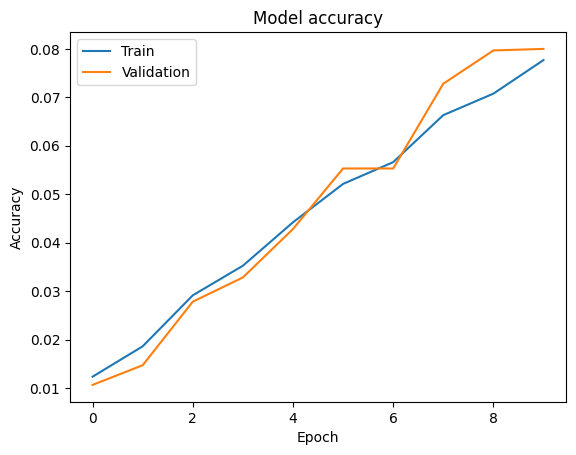

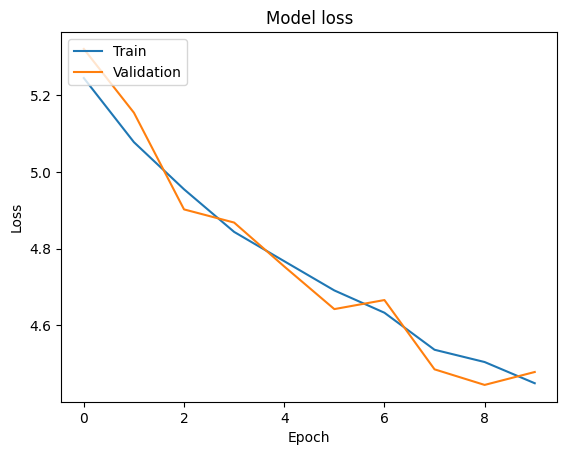

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

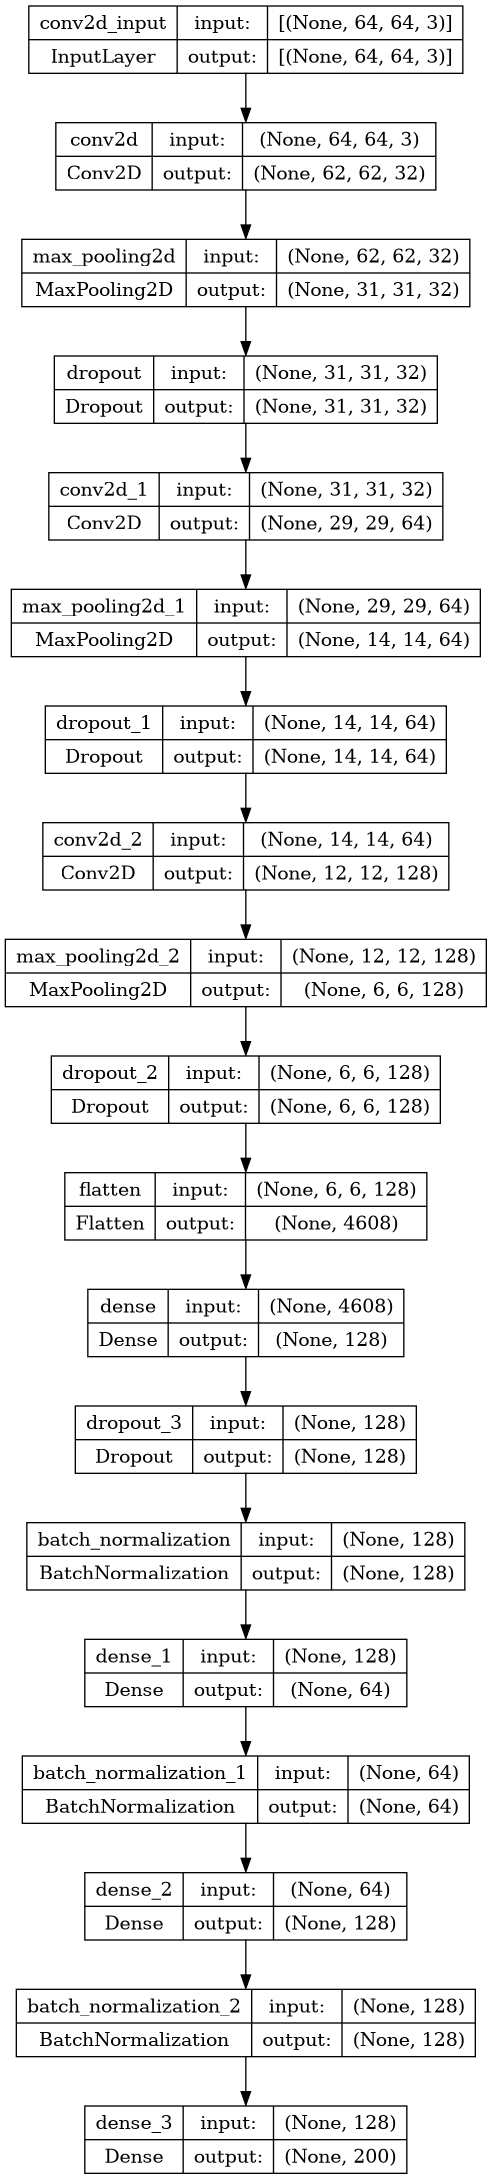

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='conv2d_model.png', show_shapes=True, show_layer_names=True)